# Visualizing Population and Unemployment Data

In [1]:
# !sudo pip3 install cython
# !sudo pip3 install cartopy
# !sudo pip3 install geoplot
# !sudo pip3 install descartes
# !sudo pip3 install pysal
# !sudo pip3 install geopandas

In [2]:
# !sudo -H pip3 install -U pip cython cartopy geoplot descartes pysal geopandas pandas numpy requests

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import requests # to connect to the Census API
import ast # for parsing the Census API response

import pandas as pd
import numpy as np

import geopandas as gpd
import geoplot
import geoplot.crs as gcrs

In [4]:
# To plot the choropleths, we need the shapefiles for the areas. Below we use 
# shapefiles that come from the US Census data
# 
# More files at https://www.census.gov/geo/maps-data/data/tiger-cart-boundary.html
# 
# Check also http://geojson.xyz/ for more shapefiles
#
shapefiles_zipcodes = "http://www2.census.gov/geo/tiger/GENZ2017/shp/cb_2017_us_zcta510_500k.zip"
shapefiles_counties = "http://www2.census.gov/geo/tiger/GENZ2017/shp/cb_2017_us_county_500k.zip"
shapefiles_states   = "http://www2.census.gov/geo/tiger/GENZ2017/shp/cb_2017_us_state_500k.zip"

## Load GeoDataframe for US States and plot a map

In [5]:
df_states = gpd.read_file(shapefiles_states)

In [6]:
# df_states

In [7]:
# Dropping non-continental states
df_states = df_states[ df_states.NAME!='Alaska' ] 
df_states = df_states[ df_states.NAME!='Hawaii' ] 
df_states = df_states[ df_states.NAME!='Puerto Rico' ] 
df_states = df_states[ df_states.NAME!='Guam' ] 
df_states = df_states[ df_states.NAME!='Commonwealth of the Northern Mariana Islands' ] 
df_states = df_states[ df_states.NAME!='American Samoa' ] 
df_states = df_states[ df_states.NAME!='United States Virgin Islands' ] 

In [8]:
# Should be 49. The 48 continental, plus DC
assert( len(df_states) == 49 )

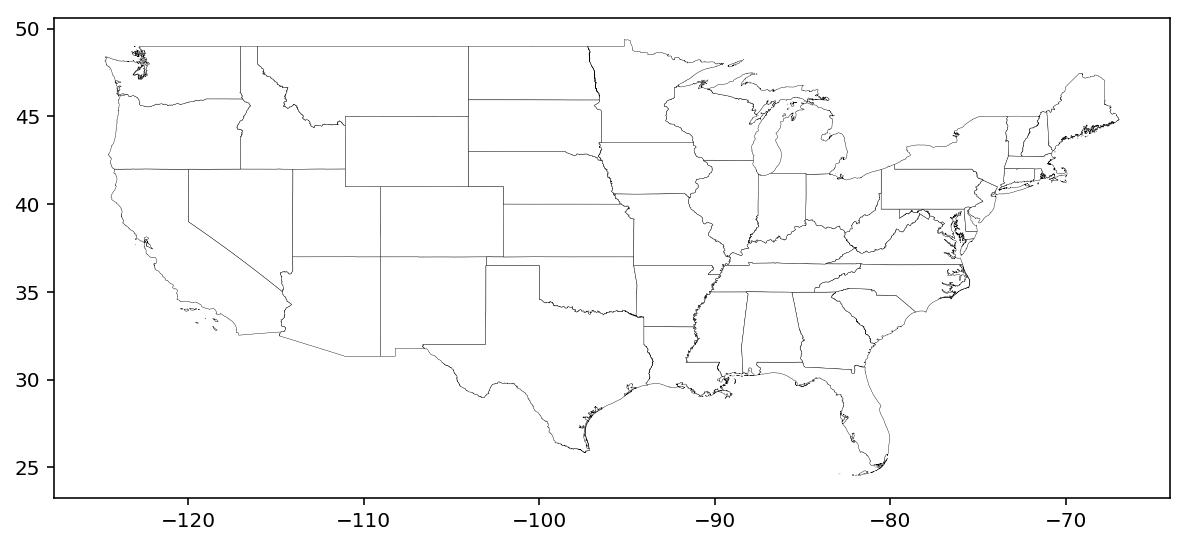

In [9]:
df_states.plot(
    figsize=(10,10), 
    linewidth=0.2, 
    color='white', 
    edgecolor='black'
)

## Load US Counties Datafame and plot a map

In [10]:
df_counties = gpd.read_file(shapefiles_counties)

In [11]:
# df_counties

In [12]:
len(df_counties)

3233

In [13]:
# There should be 3233 counties looaded
assert( len(df_counties) == 3233 )

In [14]:
# Keep only counties in the lower 48 states + DC
keep_county = df_counties.STATEFP.isin(df_states.STATEFP.values)
df_counties = df_counties[ keep_county ]

In [15]:
# There should be 3108 counties remaining
assert(len(df_counties) == 3108)

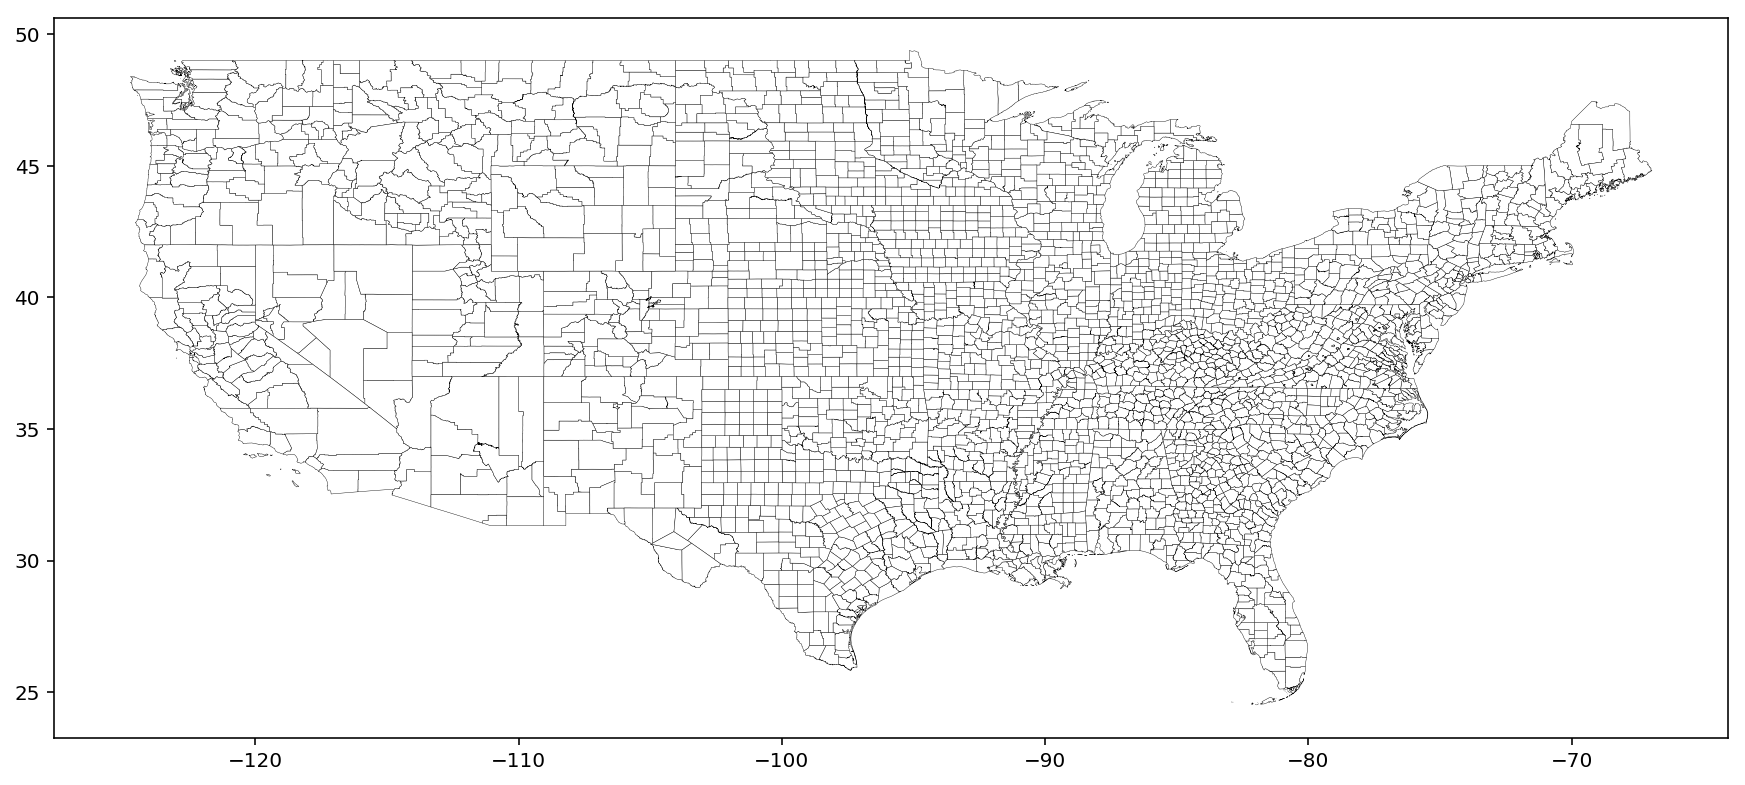

In [16]:
df_counties.plot(
    figsize=(15,15), 
    linewidth=0.2,  
    color='white', 
    edgecolor='black'
)

## Getting Census Data

You need to get an API Key from http://api.census.gov/data/key_signup.html.

In [17]:
class Census:
    def __init__(self, key):
        self.key = key

    def get(self, fields, geo, year=2010, dataset='sf1'):
        fields = [','.join(fields)]
        template_url = 'https://api.census.gov/data/{year}/{dataset}?key={key}&get='
        base_url = template_url.format(year=str(year), dataset=dataset, key=self.key)
        query = fields
        for item in geo:
            query.append(item)
        add_url = '&'.join(query)
        url = base_url + add_url
        response = requests.get(url)
        return ast.literal_eval(response.text) 

api_key = '627d4107b57d4576f2120d2b87b59c7440e5d2af'
census = Census(api_key)

## Plot a Choropleth with Population of US States

In [18]:
# Fetch state population data from US Census
census_response = census.get(['P0010001'], ['for=state:*'])
# Manipulate the result from the US Census API and convert the result to a dataframe
df_state_population = pd.DataFrame(census_response[1:], columns = ['Population', 'STATEFP'])
df_state_population['Population'] = pd.to_numeric(df_state_population['Population'])
df_state_population['LogPopulation'] = np.log10(df_state_population['Population'])
# df_state_population

In [19]:
# ax = df_state_population.LogPopulation.hist()
# df_state_population.LogPopulation.plot.kde(secondary_y=True, ax = ax)

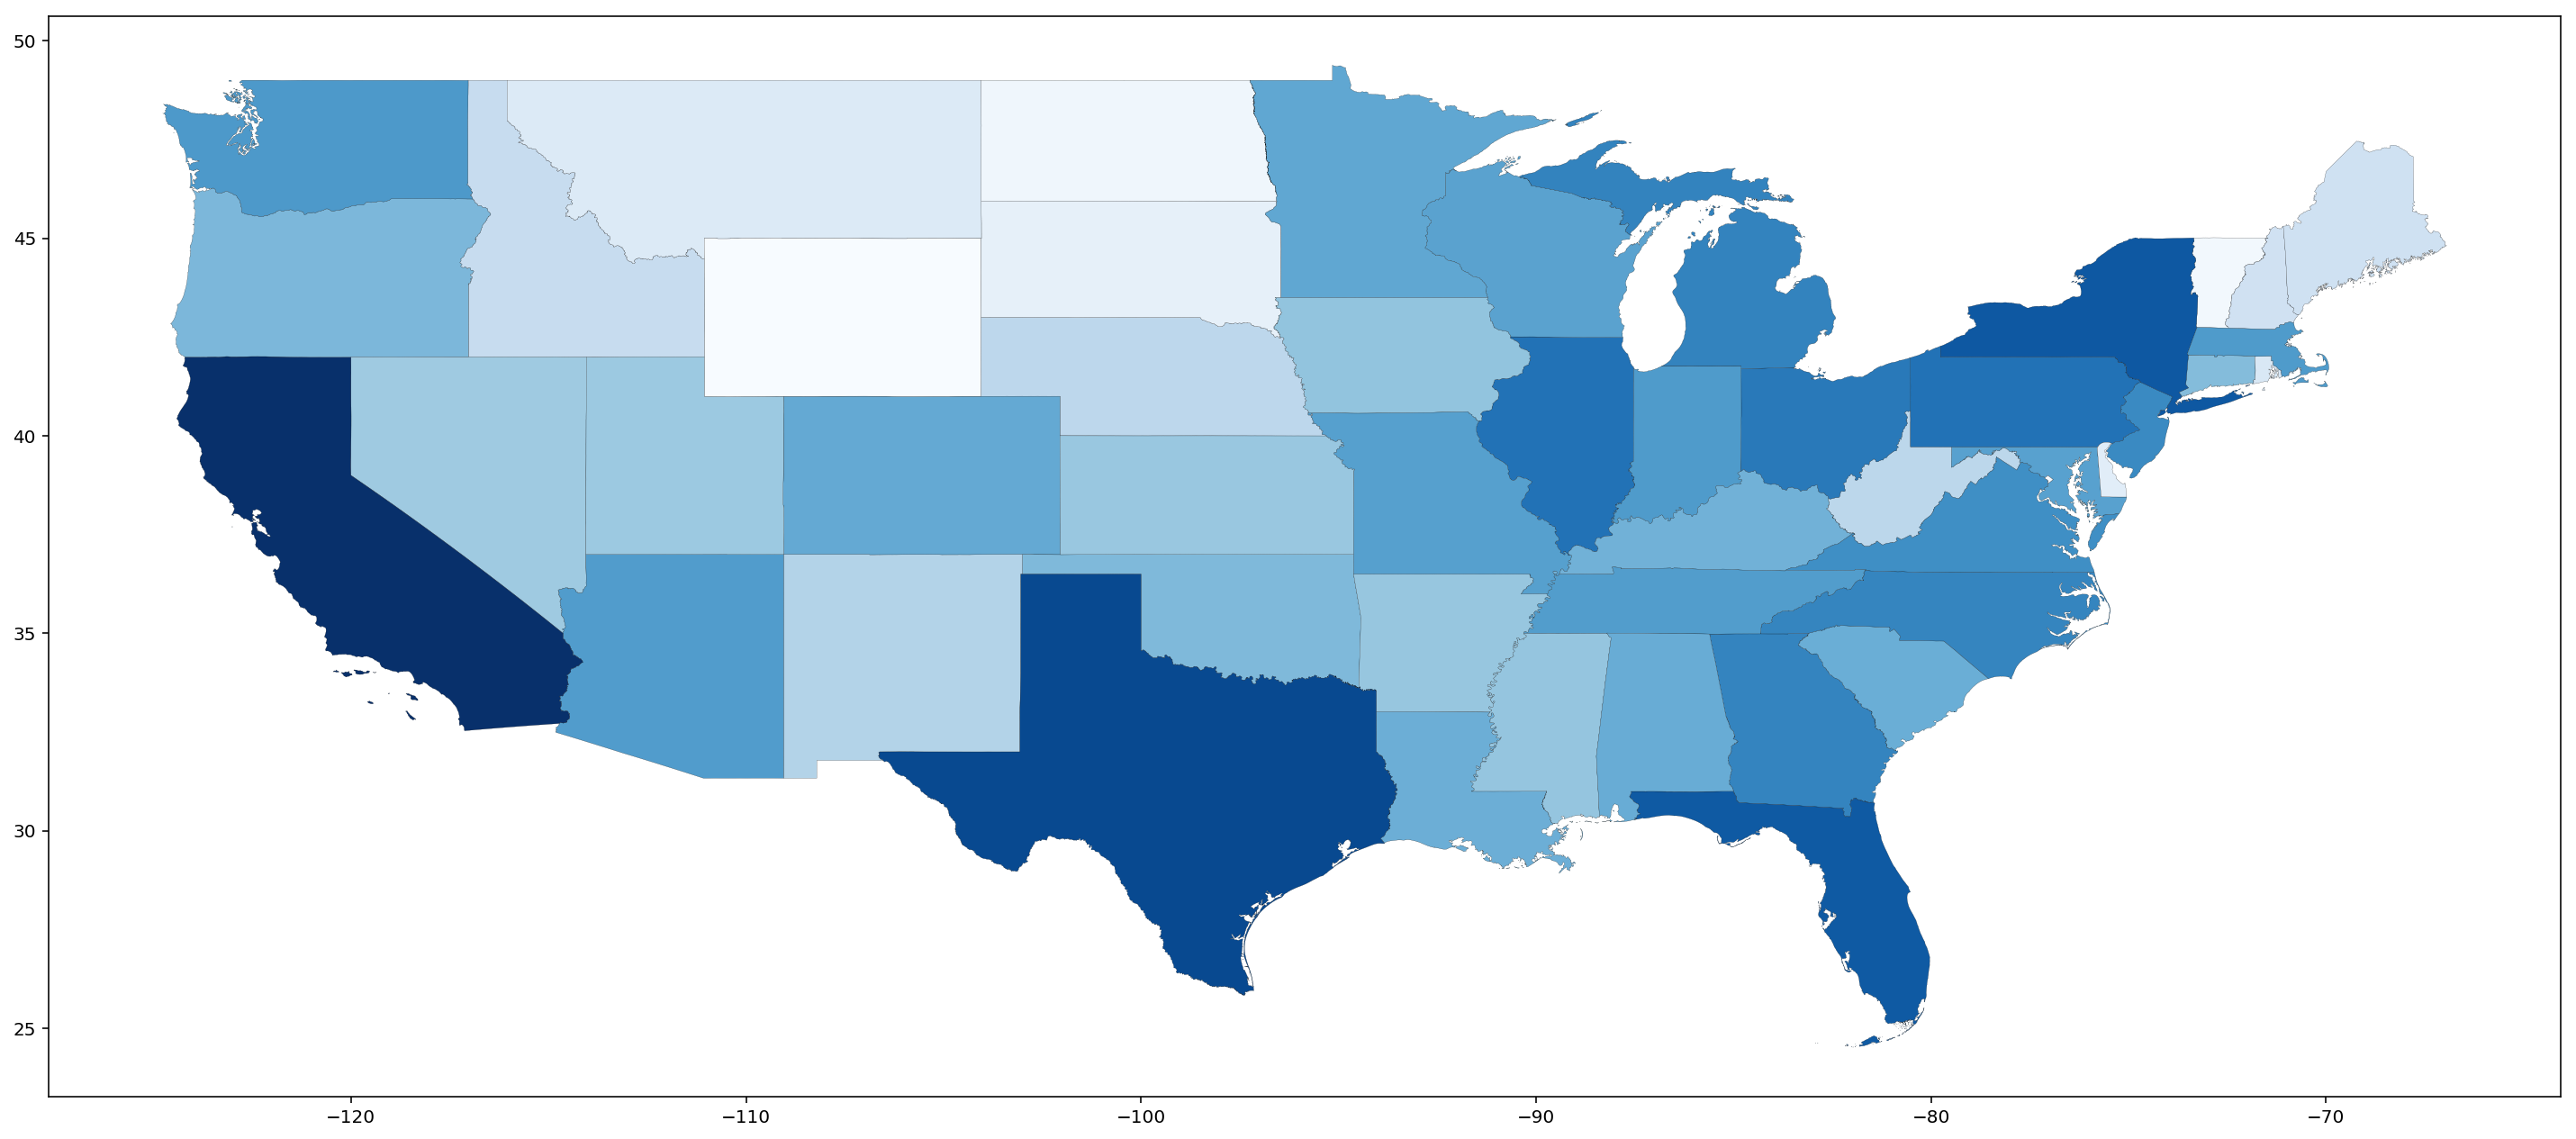

In [20]:
# Augment the df_states geodataframe with population information
states_choropleth = pd.merge(df_states, df_state_population, on='STATEFP')

states_choropleth.plot(
    figsize=(25,25), 
    column='LogPopulation', 
    cmap='Blues',  # select color scheme from http://matplotlib.org/users/colormaps.html
    linewidth=0.1, 
    edgecolor='black'
)

## Plot a Choropleth with Population of US Counties

In [21]:
# Query the US Census API for the population of each county
census_response = census.get(['P0010001'], ['in=state:*', 'for=county:*'])
# Manipulate the API response and put the results in a dataframe
df_county_population = pd.DataFrame(census_response[1:], columns = ['Population', 'STATEFP', 'COUNTYFP'])
df_county_population['Population'] = pd.to_numeric(df_county_population['Population'])
df_county_population['LogPopulation'] = np.log10(df_county_population['Population'])
# df_county_population

In [22]:
df_county_population.head(5)

Population STATEFP COUNTYFP  LogPopulation
0       54571      01      001       4.736962
1      182265      01      003       5.260703
2       27457      01      005       4.438653
3       22915      01      007       4.360120
4       57322      01      009       4.758321

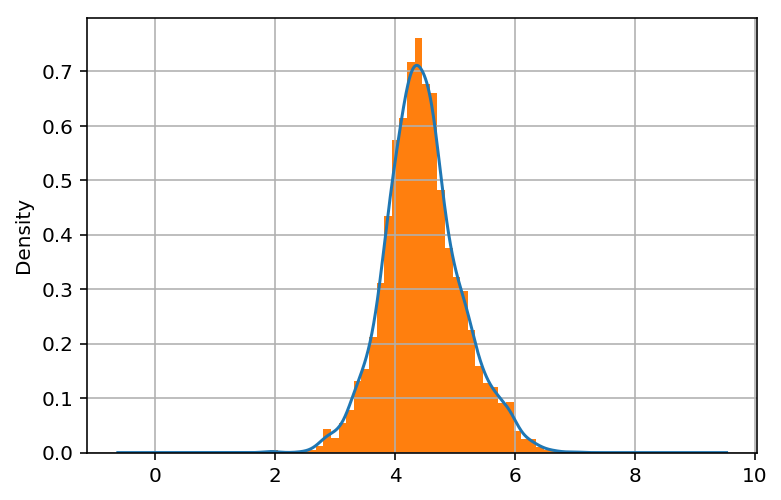

In [23]:
df_county_population.LogPopulation.plot.kde()
df_county_population.LogPopulation.hist(bins=40, density=True)

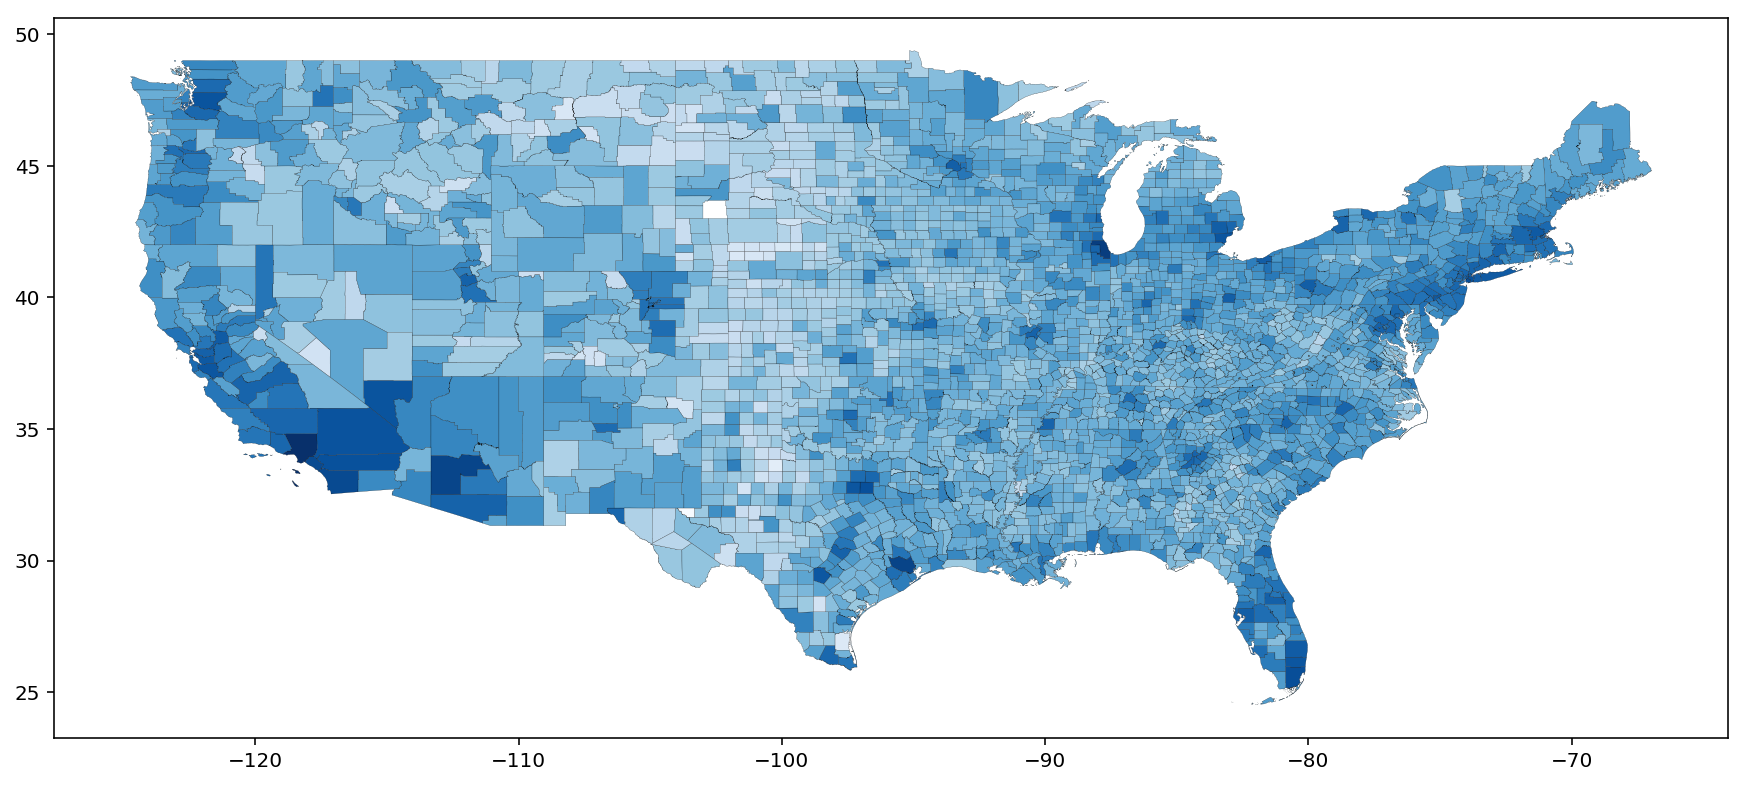

In [24]:
# Merge the GeoDataFrame df_counties with the population data
counties_choropleth = pd.merge(df_counties, df_county_population, on=['STATEFP', 'COUNTYFP'])

counties_choropleth.plot(
    figsize=(15,15), 
    column='LogPopulation', 
    cmap='Blues', # http://matplotlib.org/users/colormaps.html
    # scheme='Quantiles', # alternatives are 'Quantiles', Equal_Interval', and 'Fisher_Jenks'; Quantiles requires PySAL
    linewidth=0.1, 
    edgecolor='black')

## Extras

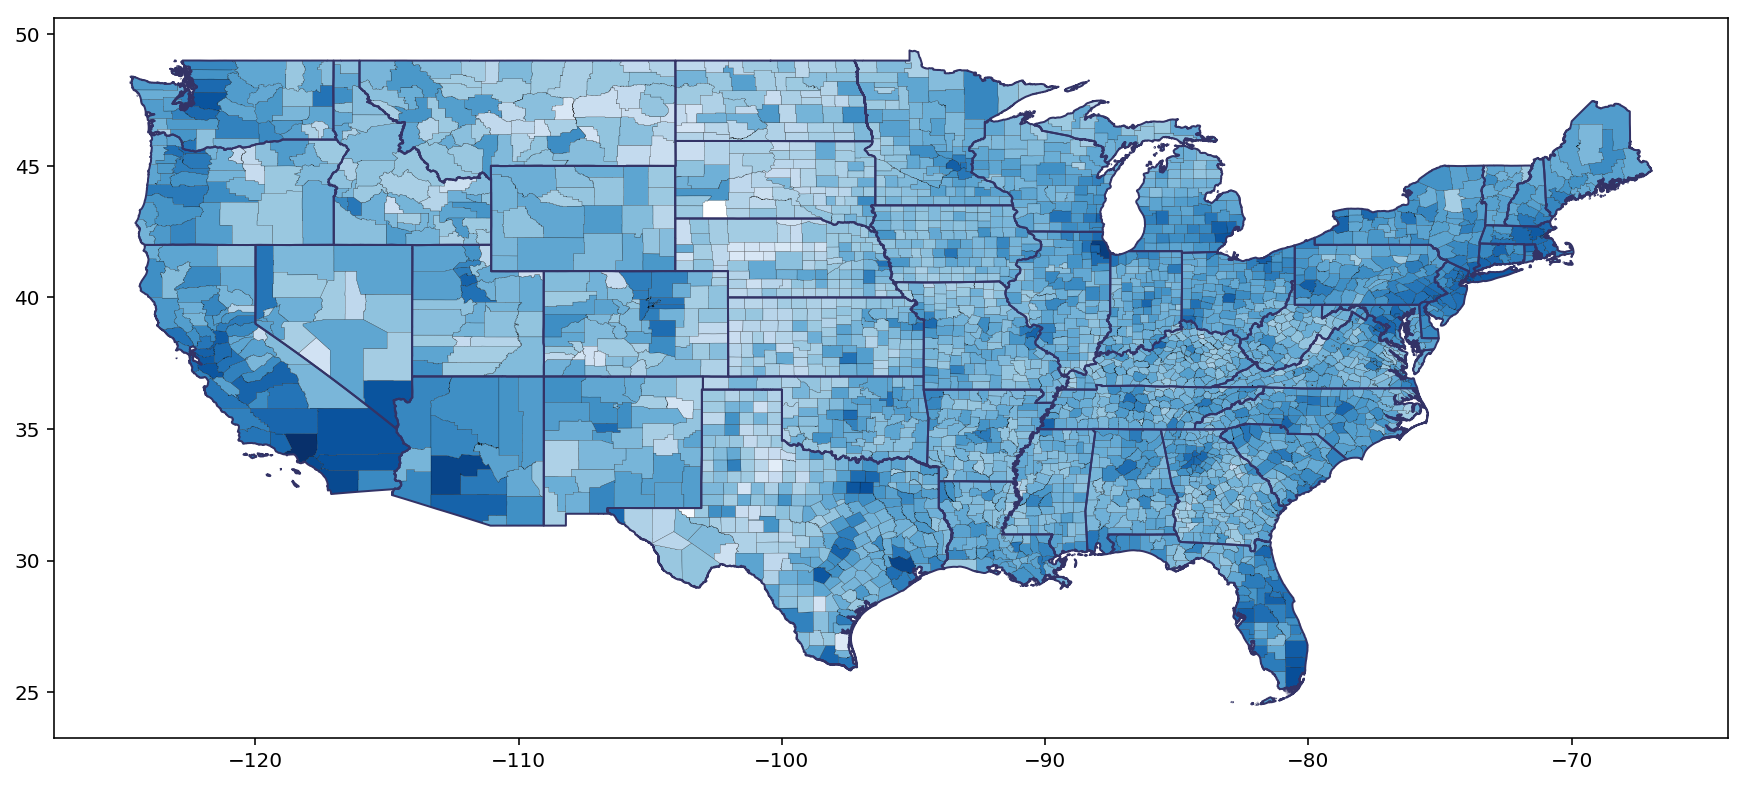

In [25]:
# Plot the state borders (with darker, thicker lines) on top of the counties

ax = counties_choropleth.plot(
    figsize=(15,15), 
    column='LogPopulation', 
    cmap='Blues', # http://matplotlib.org/users/colormaps.html
    # scheme='Quantiles', # alternatives are 'Quantiles', Equal_Interval', and 'Fisher_Jenks'; Quantiles requires PySAL
    linewidth=0.1, 
    edgecolor='black')

df_states.plot(
    figsize=(15,15), 
    linewidth=1, # thicker line
    facecolor='none', # no color for fill
    edgecolor='#333366', # color for the state borders
    ax = ax # plot it on top of the counties plot
)


/usr/local/lib/python3.6/dist-packages/pysal/__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysal` 2.0 prelease candidate. The API changes and a guide on how to change imports is provided at https://pysal.org/about
  ), VisibleDeprecationWarning)


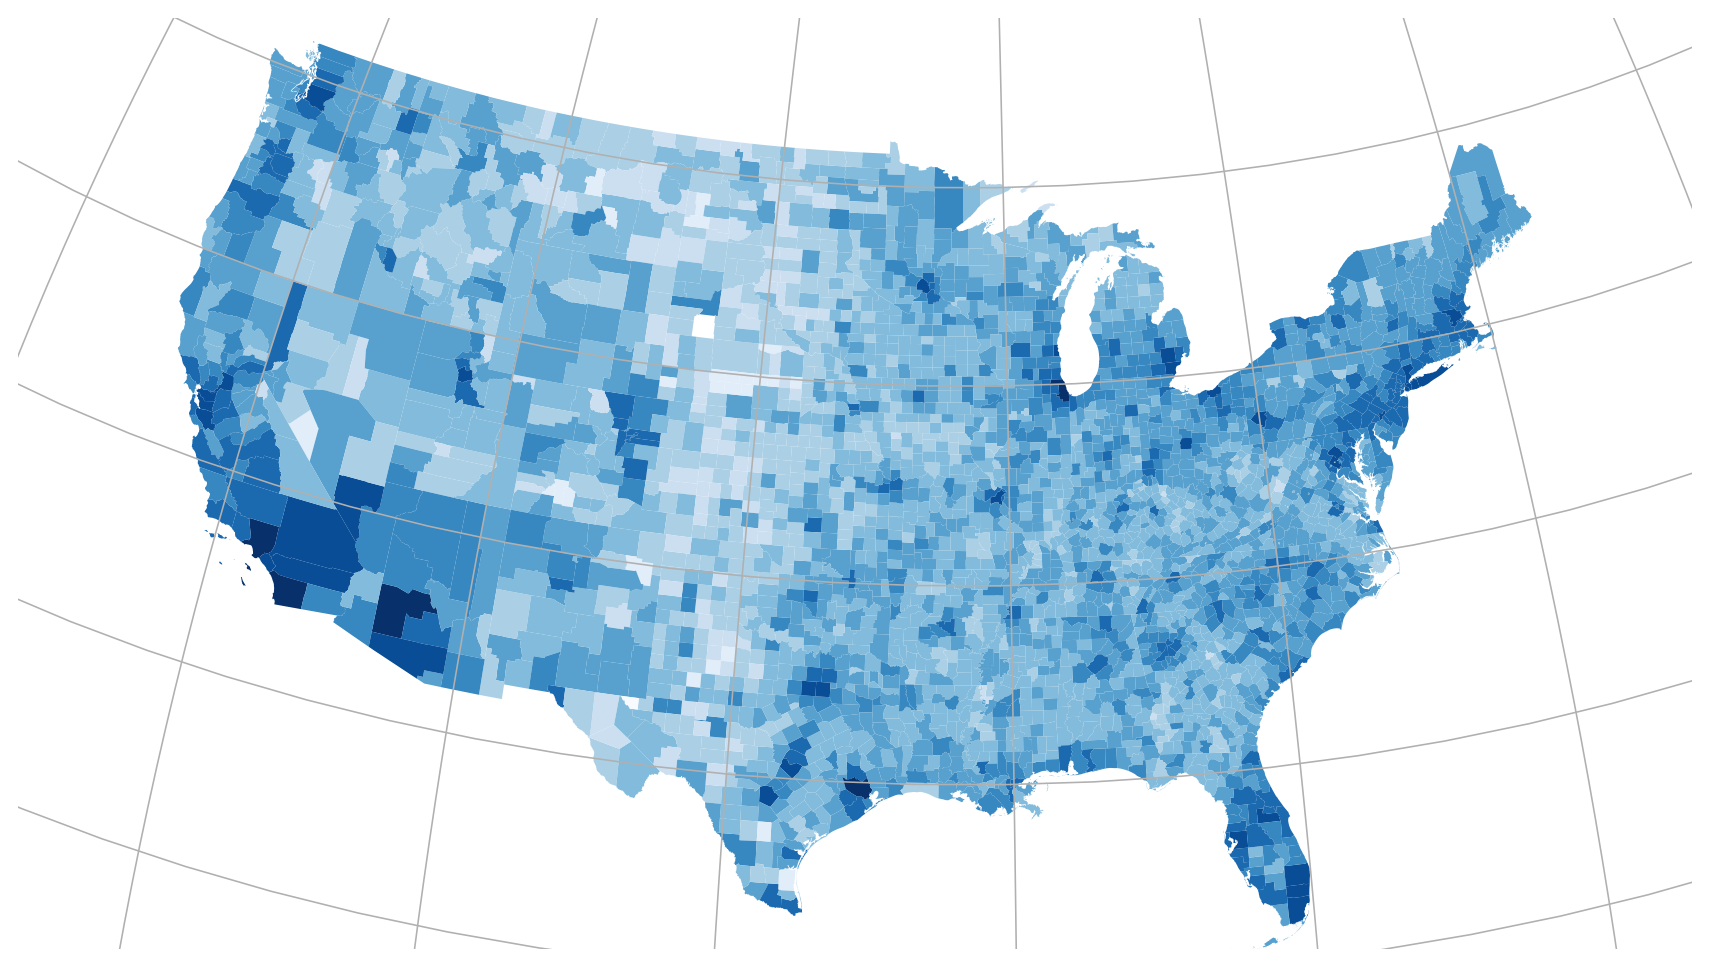

In [26]:
# Changing the projection to Orthographic
geoplot.choropleth(
    counties_choropleth,
    hue='LogPopulation',
    categorical=False, # LogPopulation is continuous not categorical
    k=10, # split LogPopulation into 10 bins for coloring
    scheme='equal_interval', # Each bin has equal range for LogPopulation
    cmap='Blues', # try Spectral_r, Spectral, or others from https://matplotlib.org/tutorials/colors/colormaps.html
    linewidth=0.3,
    projection=gcrs.Orthographic(),
    figsize=(15, 15)
).gridlines() # plot gridlines

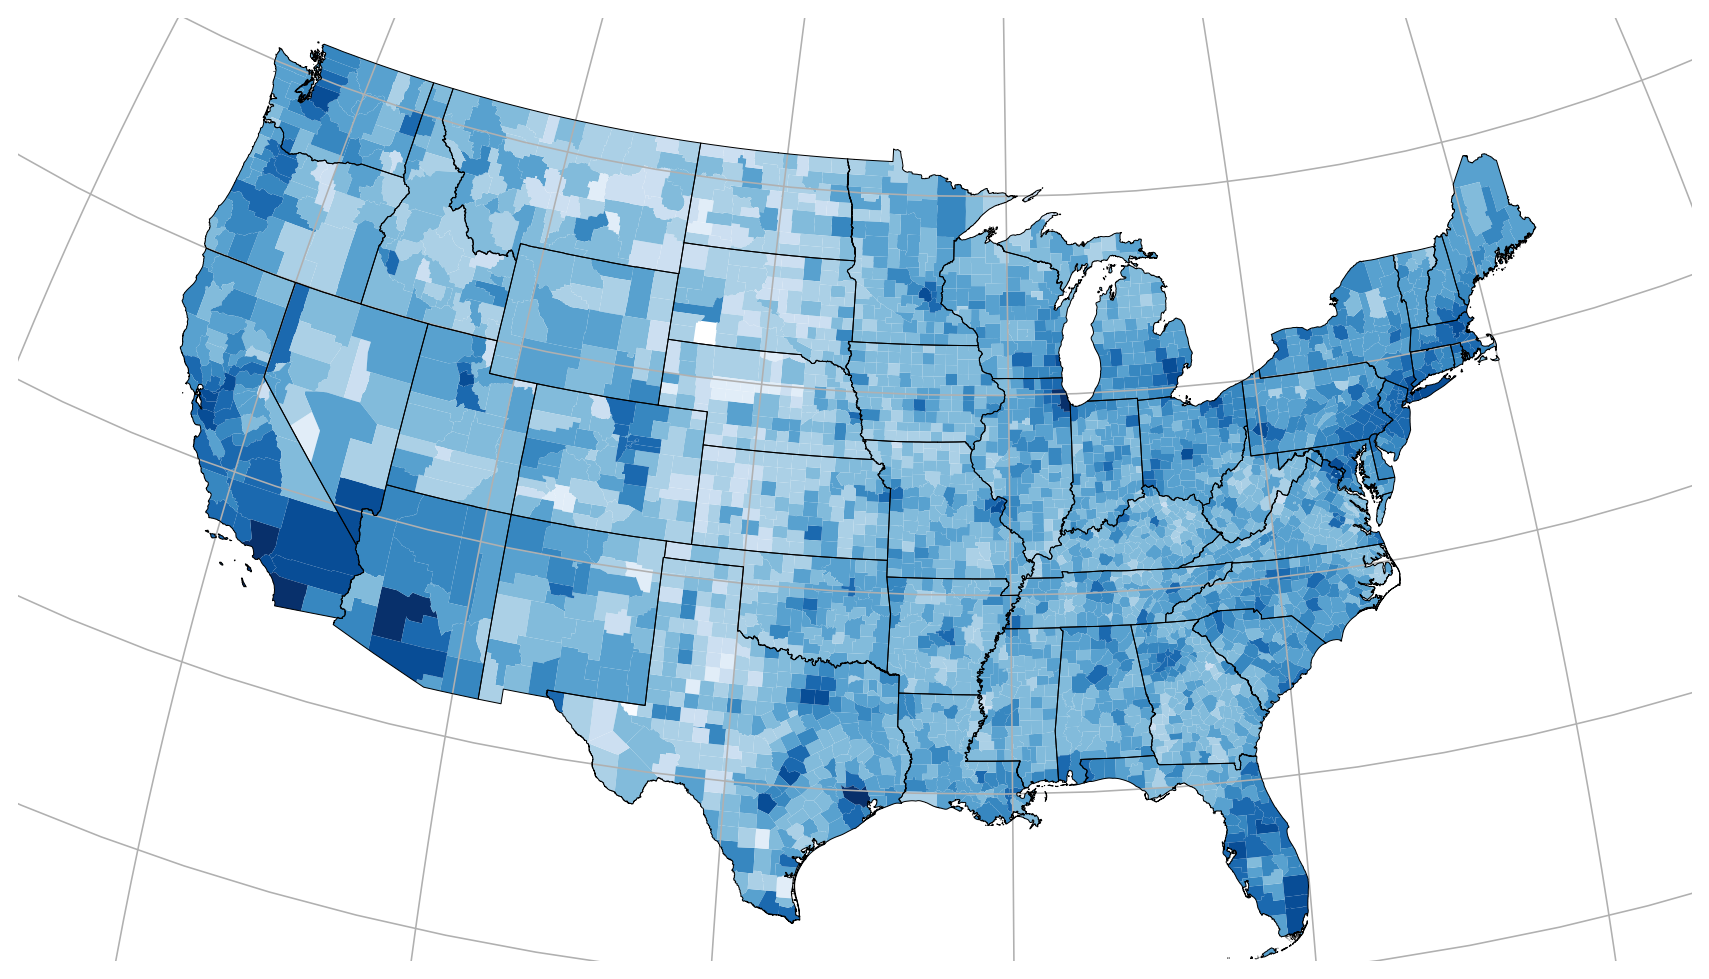

In [27]:
# Add state borders in the geoplot choropleth plot

ax = geoplot.polyplot(
    states_choropleth, 
    projection=gcrs.Orthographic(),
    figsize=(15, 15),
    linewidth = 0.5,
    zorder = 2
)

geoplot.choropleth(
    counties_choropleth,
    hue='LogPopulation',
    categorical=False, # LogPopulation is continuous not categorical
    k=10, # split LogPopulation into 40 bins for coloring
    scheme='equal_interval', # Each bin has equal range for LogPopulation
    cmap='Blues', # try Spectral_r, Spectral, or others from https://matplotlib.org/tutorials/colors/colormaps.html
    linewidth=0.3,
    projection=gcrs.Orthographic(),
    figsize=(15, 15),
    ax = ax,
    zorder = 0
).gridlines(zorder=1) # plot gridlines



## Unemployment Data

https://www.bls.gov/lau/
    
 * Labor force data by county, not seasonally adjusted, latest 14 months https://www.bls.gov/web/metro/laucntycur14.txt
 
 * Labor force data by county, 2017 annual averages https://www.bls.gov/lau/laucnty17.txt 

In [28]:
url = "https://www.bls.gov/web/metro/laucntycur14.txt"
udf = pd.read_csv(
    url,
    skiprows=6,  # skip the first six lines; 
    header=None,  # we will supply the headers ourselves
    skipfooter=6,  # the last six lines are notes; skip them
    engine='python',  # we need this to use the skipfooter option
    delimiter="|",  # use | as the column delimeter
    # skipinitialspace=True,  # ignore the space characters after the delimeter |
    # thousands=",",  # specify that numbers use , for thousand separator
)

In [29]:
udf.head(5)

0  1  2                                           3  \
0   CN0100100000000   1  1   Autauga County, AL                          
1   CN0100300000000   1  3   Baldwin County, AL                          
2   CN0100500000000   1  5   Barbour County, AL                          
3   CN0100700000000   1  7   Bibb County, AL                             
4   CN0100900000000   1  9   Blount County, AL                           

             4             5             6           7    8  
0     Aug-17         25,793        24,778       1,015   3.9  
1     Aug-17         92,994        89,451       3,543   3.8  
2     Aug-17          8,275         7,780         495   6.0  
3     Aug-17          8,479         8,118         361   4.3  
4     Aug-17         24,544        23,573         971   4.0

In [30]:
udf.dtypes

0     object
1      int64
2      int64
3     object
4     object
5     object
6     object
7     object
8    float64
dtype: object

In [31]:
udf.columns = ["LAUS", "STATEFP", "COUNTYFP", "County_Name", "Period", 
               "Labor_Force", "Employed", "Unemployed", "Rate"]

In [32]:
udf.head(5)

LAUS  STATEFP  COUNTYFP  \
0   CN0100100000000         1         1   
1   CN0100300000000         1         3   
2   CN0100500000000         1         5   
3   CN0100700000000         1         7   
4   CN0100900000000         1         9   

                                  County_Name       Period   Labor_Force  \
0   Autauga County, AL                            Aug-17         25,793    
1   Baldwin County, AL                            Aug-17         92,994    
2   Barbour County, AL                            Aug-17          8,275    
3   Bibb County, AL                               Aug-17          8,479    
4   Blount County, AL                             Aug-17         24,544    

       Employed  Unemployed  Rate  
0       24,778       1,015    3.9  
1       89,451       3,543    3.8  
2        7,780         495    6.0  
3        8,118         361    4.3  
4       23,573         971    4.0

In [33]:
udf.dtypes

LAUS            object
STATEFP          int64
COUNTYFP         int64
County_Name     object
Period          object
Labor_Force     object
Employed        object
Unemployed      object
Rate           float64
dtype: object

In [34]:
# Convert STATEFP and COUNTYFP to strings and add leading zeros
# to allow for merging later on with the geodataframes
# Interestingly, the initial file contains the zeros, but Pandas recognizes
# the entries as numbers and converts to integers, so we are forced to convert back
udf.STATEFP = udf.STATEFP.apply(str).str.zfill(2)
udf.COUNTYFP = udf.COUNTYFP.apply(str).str.zfill(3)

In [35]:
udf.head(5)

LAUS STATEFP COUNTYFP  \
0   CN0100100000000       01      001   
1   CN0100300000000       01      003   
2   CN0100500000000       01      005   
3   CN0100700000000       01      007   
4   CN0100900000000       01      009   

                                  County_Name       Period   Labor_Force  \
0   Autauga County, AL                            Aug-17         25,793    
1   Baldwin County, AL                            Aug-17         92,994    
2   Barbour County, AL                            Aug-17          8,275    
3   Bibb County, AL                               Aug-17          8,479    
4   Blount County, AL                             Aug-17         24,544    

       Employed  Unemployed  Rate  
0       24,778       1,015    3.9  
1       89,451       3,543    3.8  
2        7,780         495    6.0  
3        8,118         361    4.3  
4       23,573         971    4.0

In [36]:
# Using the thousands=","  option in read_csv allows Pandas to understand the 
# data type of these columns properly. If we do not use the option, the 
# code below can convert the values into recognizable numbers to be used by to_numeric
# 
# Need to replace the comma-separator in the numbers with an empty character
# to allow for proper conversion
#
udf.Labor_Force = pd.to_numeric(udf.Labor_Force.str.replace(',',''))
udf.Employed = pd.to_numeric(udf.Employed.str.replace(',',''))
udf.Unemployed = pd.to_numeric(udf.Unemployed.str.replace(',',''))

In [37]:
# We now want to convert the "Period" to datetime
# Let's take a look at the unique values
udf.Period.drop_duplicates()

0           Aug-17  
3219        Sep-17  
6360      Sep-17(y) 
6438        Oct-17  
9657        Nov-17  
12876       Dec-17  
16095       Jan-18  
19314       Feb-18  
22533       Mar-18  
25752       Apr-18  
28971       May-18  
32190       Jun-18  
35409       Jul-18  
38628       Aug-18  
41847     Sep-18(p) 
Name: Period, dtype: object

In [38]:
# Converting "Period" to a proper date
# We will need to remove spaces 
# We will also need to remove the notes (p) and (y); we need to escape the parentheses
udf.Period = udf.Period.str.replace(' ','')
udf.Period = udf.Period.str.replace('\(p\)','')
udf.Period = udf.Period.str.replace('\(y\)','')
udf.Period.drop_duplicates()

0        Aug-17
3219     Sep-17
6438     Oct-17
9657     Nov-17
12876    Dec-17
16095    Jan-18
19314    Feb-18
22533    Mar-18
25752    Apr-18
28971    May-18
32190    Jun-18
35409    Jul-18
38628    Aug-18
41847    Sep-18
Name: Period, dtype: object

In [39]:
udf.Period = pd.to_datetime(udf.Period, format='%b-%y')

In [40]:
udf.head(5)

LAUS STATEFP COUNTYFP  \
0   CN0100100000000       01      001   
1   CN0100300000000       01      003   
2   CN0100500000000       01      005   
3   CN0100700000000       01      007   
4   CN0100900000000       01      009   

                                  County_Name     Period  Labor_Force  \
0   Autauga County, AL                        2017-08-01        25793   
1   Baldwin County, AL                        2017-08-01        92994   
2   Barbour County, AL                        2017-08-01         8275   
3   Bibb County, AL                           2017-08-01         8479   
4   Blount County, AL                         2017-08-01        24544   

   Employed  Unemployed  Rate  
0     24778        1015   3.9  
1     89451        3543   3.8  
2      7780         495   6.0  
3      8118         361   4.3  
4     23573         971   4.0

In [41]:
udf.dtypes

LAUS                   object
STATEFP                object
COUNTYFP               object
County_Name            object
Period         datetime64[ns]
Labor_Force             int64
Employed                int64
Unemployed              int64
Rate                  float64
dtype: object

In [42]:
unemployment_average = udf.pivot_table(
    index = ['STATEFP','COUNTYFP', 'County_Name'],
    values = 'Rate',
    aggfunc = 'mean'
)

unemployment_average = unemployment_average.reset_index()

unemployment_average.head(5)

STATEFP COUNTYFP                                 County_Name      Rate
0      01      001   Autauga County, AL                         3.550000
1      01      003   Baldwin County, AL                         3.571429
2      01      005   Barbour County, AL                         5.357143
3      01      007   Bibb County, AL                            3.885714
4      01      009   Blount County, AL                          3.528571

In [43]:
unemployment_average.Rate.describe()

count    3219.000000
mean        4.432976
std         2.004986
min         1.342857
25%         3.264286
50%         4.035714
75%         5.017857
max        19.957143
Name: Rate, dtype: float64

In [44]:
# County with the highest unemployment rate
unemployment_average [ unemployment_average.Rate == unemployment_average.Rate.max() ]

STATEFP COUNTYFP                                 County_Name       Rate
81      02      158   Kusilvak Census Area, AK                   19.957143

In [45]:
# County with the lowest unemployment rate
unemployment_average [ unemployment_average.Rate == unemployment_average.Rate.min() ]

STATEFP COUNTYFP                                 County_Name      Rate
2000      38      023   Divide County, ND                          1.342857

In [46]:
# County with the median unemployment rate
unemployment_average [ unemployment_average.Rate == unemployment_average.Rate.median() ]

STATEFP COUNTYFP                                 County_Name      Rate
56        01      113   Russell County, AL                         4.035714
142       05      063   Independence County, AR                    4.035714
190       06      009   Calaveras County, CA                       4.035714
310       09      005   Litchfield County, CT                      4.035714
400       13      027   Brooks County, GA                          4.035714
905       20      037   Crawford County, KS                        4.035714
2513      47      173   Union County, TN                           4.035714

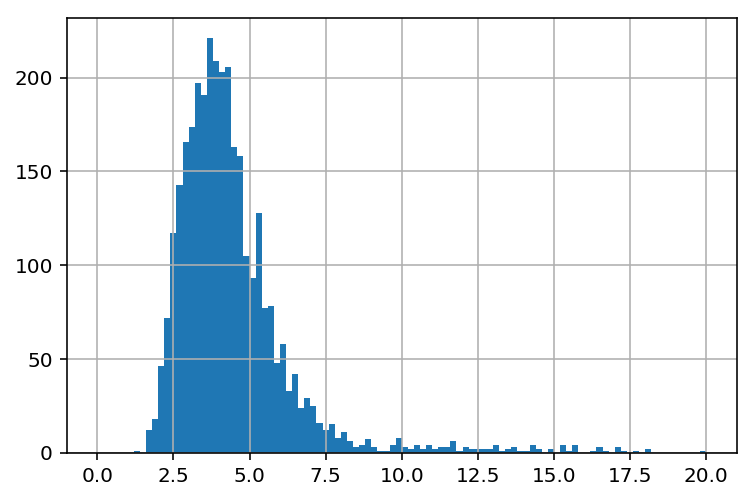

In [47]:
unemployment_average.Rate.hist(bins=100,range=(0,20))

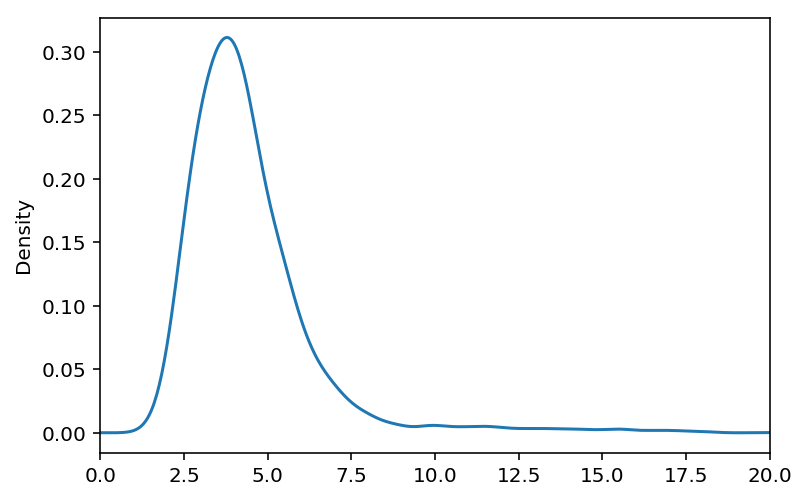

In [48]:
unemployment_average.Rate.plot.kde(xlim=(0,20))

Text(0.5,0,'Unemployment Rate (%)')

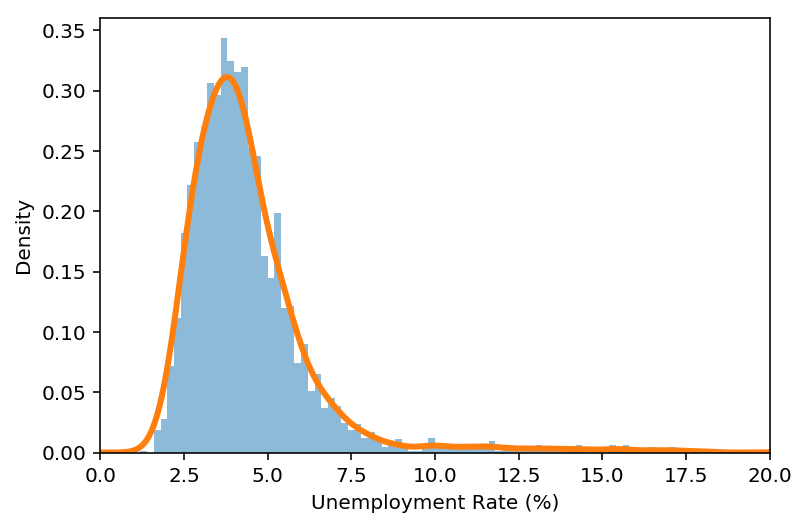

In [49]:
ax = unemployment_average.Rate.hist(bins=100,range=(0,20), density=True, alpha=0.5)
ax = unemployment_average.Rate.plot.kde(xlim=(0,20), ax=ax, linewidth=3)
ax.set_xlabel("Unemployment Rate (%)")

In [50]:
# Merge the GeoDataFrame df_counties with the unemployment data
# Note that this will drop the rates for counties in Alaska and Hawaii
# as this is an inner join, and we have dropped from df_counties Alaska and Hawaii
unemployment_choropleth = pd.merge(df_counties, unemployment_average, on=['STATEFP', 'COUNTYFP'])

In [51]:
unemployment_choropleth.head(5)

STATEFP COUNTYFP  COUNTYNS        AFFGEOID  GEOID     NAME LSAD       ALAND  \
0      01      005  00161528  0500000US01005  01005  Barbour   06  2292144656   
1      01      023  00161537  0500000US01023  01023  Choctaw   06  2365869837   
2      01      035  00161543  0500000US01035  01035  Conecuh   06  2201948618   
3      01      051  00161551  0500000US01051  01051   Elmore   06  1601762124   
4      01      065  00161558  0500000US01065  01065     Hale   06  1667907107   

     AWATER                                           geometry  \
0  50538698  POLYGON ((-85.74803199999999 31.619181, -85.74...   
1  19144469  POLYGON ((-88.47322699999999 31.893856, -88.46...   
2   6643480  POLYGON ((-87.42720399999999 31.26436, -87.425...   
3  99965171  POLYGON ((-86.41333499999999 32.750591, -86.37...   
4  32423356  POLYGON ((-87.870464 32.762442, -87.868184 32....   

                                  County_Name      Rate  
0   Barbour County, AL                         5.357143  
1   Choctaw County, AL                         5.835714  
2   Conecuh County, AL                         5.257143  
3   Elmore County, AL                          3.400000  
4   Hale County, AL                            5.142857

In [ ]:
# Compare with https://www.bls.gov/web/metro/twmcort.pdf

ax = geoplot.polyplot(
    states_choropleth, 
    projection=gcrs.Orthographic(),
    figsize=(15, 15),
    linewidth = 0.5,
    zorder = 2
)

geoplot.choropleth(
    unemployment_choropleth,
    hue='Rate',
    categorical=False, # Unemployment rate is continuous not categorical
    k=10, # split Unemployment into 10 bins for coloring
    scheme='quantiles', # Use quantiles for creating the bins
    cmap='coolwarm', # We use a **divergent** colormap, to show places with higher than average and lower than average https://matplotlib.org/tutorials/colors/colormaps.html
    linewidth=0.3,
    projection=gcrs.Orthographic(),
    figsize=(15, 15),
    ax = ax,
    zorder = 0,
    legend = True,
    legend_kwargs={'loc': 'lower right'}
).gridlines(zorder=1) # plot gridlines on top of the counties (zorder=0), but behind state lines (zorder=2)



/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


### Extracting quantiles as a separate column

In [ ]:
num_quantiles = 10

In [ ]:
quantiles = pd.qcut(unemployment_choropleth.Rate, num_quantiles)

In [ ]:
# Let's see the ranges for the quantiles
quantiles.drop_duplicates().sort_values()

In [ ]:
# We use the labels=Fase to get a number (0,1,2,3...) instead of the range labels 
unemployment_choropleth["qRate"] = pd.qcut(unemployment_choropleth.Rate, num_quantiles, labels=False)
unemployment_choropleth["Rate_range"] = pd.qcut(unemployment_choropleth.Rate, num_quantiles)

In [ ]:
unemployment_choropleth.head(5)